In [22]:
from __future__ import annotations

import random
import torch.nn as nn
import torch.autograd
import torch.nn.functional as F
import gymnasium as gym

from collections import namedtuple, deque

import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
#Create environment
env = gym.make("CartPole-v1")

In [24]:
#Create the Replay Buffer class
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [25]:
class CartPoleAgent:
    def __init__(
        self,
        model,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
    ):
        """Initialize a DQN RL agent, get action epsilon-greedily, and manage epsilon

        Args:
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            q_value_model: The DQN which outputs a Q-value for each of the two possible actions
        """
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.model = model

    def get_action(self, obs) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            return int(torch.argmax(self.model(obs)))


    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [5]:
# def get_action(state, model, epsilon) -> int:
#     """
#     Returns the best action with probability (1 - epsilon)
#     otherwise a random action with probability epsilon to ensure exploration.
#     """
#     if np.random.random() < epsilon:
#         return env.action_space.sample()
#     else:
#         return int(torch.argmax(model(state)))

In [26]:
#May need to adjust for environments other than CartPole
state_length = env.observation_space.shape[0]
possible_actions = env.action_space.n

In [27]:
#Create the model
class DQN(nn.Module):
    def __init__(self, state_length, possible_actions):
        super().__init__()
        self.fc1 = nn.Linear(state_length,128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,possible_actions)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [28]:
#Instantiate policy and target models
model = DQN(state_length=state_length, possible_actions=possible_actions)
model.to(device)
target_model = DQN(state_length=state_length, possible_actions=possible_actions)
target_model.to(device)
#Freeze target model; we will update the target model gradually from the policy model during training
for param in target_model.parameters():
    param.requires_grad = False

In [29]:
#Create/reset the replay buffer
buffer_size = 50_000
replay_buffer = ReplayMemory(buffer_size)

In [30]:
learning_rate = 0.0001
tau = 0.005

num_episodes = 300
batch_size = 128

initial_epsilon = 1.0
epsilon_decay = initial_epsilon / (num_episodes / 2)  # Reach final epsilon at 50% of num_episodes
final_epsilon = 0.01

discount_factor = 0.99

In [31]:
#Epsilon-greedy policy, used for training
agent = CartPoleAgent(
    model=model,
    initial_epsilon=initial_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [48]:
#Greedy policy, used for evaluation
agent = CartPoleAgent(
    model=model,
    initial_epsilon=0,
    epsilon_decay=0,
    final_epsilon=0,
)

In [32]:
criterion = torch.nn.HuberLoss(delta=1)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)

In [12]:
print(replay_buffer.__len__())

0


In [285]:
#Used to render and observe model, significantly slows down training
env.close()
env = gym.make("CartPole-v1", render_mode="human")

In [33]:
# Training loop
model.train()
prev_iterations = 0
iterations = 0
returns_list = []

for j in range(num_episodes):
    done = False
    current_state, _ = env.reset()
    current_state = torch.tensor(current_state, device=device).unsqueeze(0)
    
    while not done:
        effective_batch_size = min(batch_size, replay_buffer.__len__()+1)
        
        action = agent.get_action(current_state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(next_state, device=device).unsqueeze(0)

        replay_buffer.push(current_state, action, next_state, reward)
        
        transitions = replay_buffer.sample(batch_size=effective_batch_size)
        batch = Transition(*zip(*transitions))

        batch_states = torch.cat(batch.state)
        batch_rewards = torch.tensor(batch.reward, device=device)
        batch_actions = torch.tensor(batch.action, device=device)
        batch_next_states = torch.cat([s for s in batch.next_state if s is not None])

        with torch.no_grad():
            #Compute return from target network
            mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
            best_next_q_values = torch.zeros(effective_batch_size, device=device)
            best_next_q_values[mask] = torch.max(target_model(batch_next_states), 1).values
            target_q_values = batch_rewards + discount_factor*best_next_q_values


        predicted_q_values = model(batch_states)
        predicted_q_values = predicted_q_values[torch.arange(effective_batch_size), batch_actions]

        
        loss = criterion(predicted_q_values, target_q_values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Soft update target network towards policy network
        target_model_state_dict = target_model.state_dict()
        model_state_dict = model.state_dict()
        for key in model_state_dict:
            target_model_state_dict[key] = model_state_dict[key]*tau + target_model_state_dict[key]*(1-tau)
        target_model.load_state_dict(target_model_state_dict)

        iterations += 1
        current_state = next_state
        done = terminated or truncated
        
    episode_length = iterations-prev_iterations
    prev_iterations = iterations
    
    returns_list.append(episode_length)
    agent.decay_epsilon() 
    print(f"Ep: {j+1} Return: {episode_length} Eps: {agent.epsilon:.2f}")

Ep: 1 Return: 27 Eps: 0.99
Ep: 2 Return: 11 Eps: 0.99
Ep: 3 Return: 23 Eps: 0.98
Ep: 4 Return: 15 Eps: 0.97
Ep: 5 Return: 28 Eps: 0.97
Ep: 6 Return: 24 Eps: 0.96
Ep: 7 Return: 60 Eps: 0.95
Ep: 8 Return: 15 Eps: 0.95
Ep: 9 Return: 13 Eps: 0.94
Ep: 10 Return: 13 Eps: 0.93
Ep: 11 Return: 12 Eps: 0.93
Ep: 12 Return: 24 Eps: 0.92
Ep: 13 Return: 17 Eps: 0.91
Ep: 14 Return: 19 Eps: 0.91
Ep: 15 Return: 18 Eps: 0.90
Ep: 16 Return: 21 Eps: 0.89
Ep: 17 Return: 25 Eps: 0.89
Ep: 18 Return: 27 Eps: 0.88
Ep: 19 Return: 10 Eps: 0.87
Ep: 20 Return: 16 Eps: 0.87
Ep: 21 Return: 22 Eps: 0.86
Ep: 22 Return: 17 Eps: 0.85
Ep: 23 Return: 26 Eps: 0.85
Ep: 24 Return: 16 Eps: 0.84
Ep: 25 Return: 16 Eps: 0.83
Ep: 26 Return: 12 Eps: 0.83
Ep: 27 Return: 23 Eps: 0.82
Ep: 28 Return: 15 Eps: 0.81
Ep: 29 Return: 15 Eps: 0.81
Ep: 30 Return: 14 Eps: 0.80
Ep: 31 Return: 16 Eps: 0.79
Ep: 32 Return: 11 Eps: 0.79
Ep: 33 Return: 15 Eps: 0.78
Ep: 34 Return: 9 Eps: 0.77
Ep: 35 Return: 21 Eps: 0.77
Ep: 36 Return: 12 Eps: 0.76
Ep

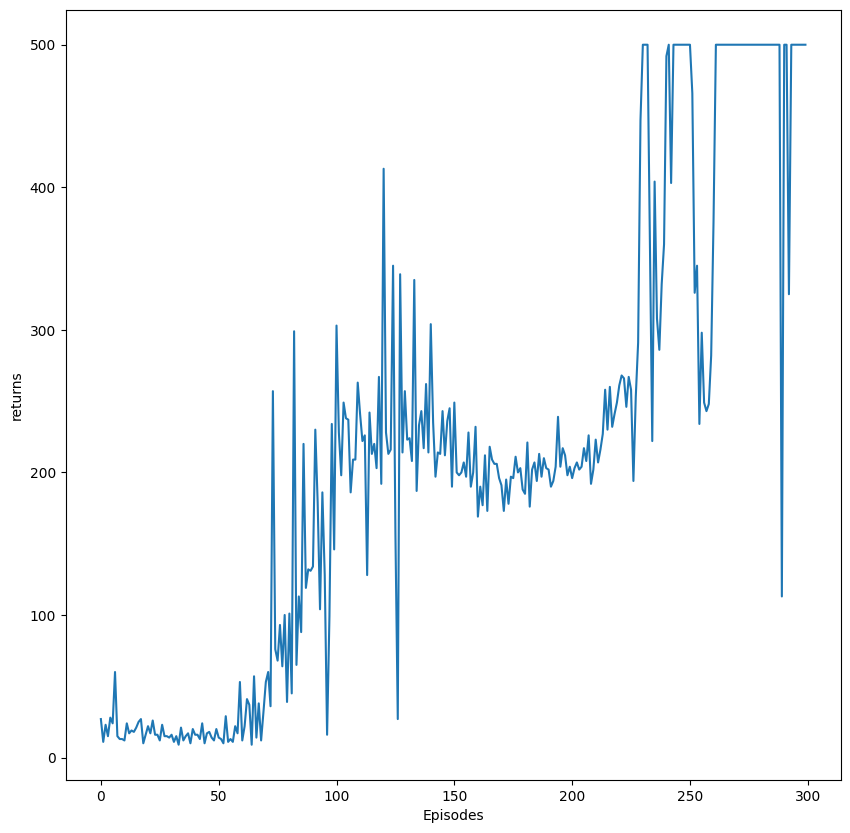

In [34]:
#Plot returns over episodes
plt.figure(figsize=(10,10))
plt.plot(range(len(returns_list)), returns_list)
plt.xlabel('Episodes')
plt.ylabel('returns')
plt.show()

In [47]:
#Stats
print(max(returns_list))
print(sum(returns_list[150:])/150)

500
218.59333333333333


In [58]:
# Save model parameters and other info
checkpoint_path = ""
additional_info = {
    'model_state_dict': model.state_dict(),
    'target_state_dict': target_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}
torch.save(additional_info, checkpoint_path)

In [ ]:
# Load model and optimizer parameters
checkpoint_path = ""
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
target_model.load_state_dict(checkpoint['target_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])